In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%cd "/content/drive/My Drive/Colab Notebooks/Python"
%ls
from error_metrics_2020 import *

/content/drive/My Drive/Colab Notebooks/Python
darnn_network_modified.py  imv_networks.py                   __pycache__/
darnn_network_russia.py    moving_window_tests_mod_dec17.py  title.jpg
error_metrics_2020.py      moving_window_tests_mod_dec28.py  utils.py
error_metrics.py           moving_window_tests.py


In [ ]:
%cd "/content/drive/My Drive/Colab Notebooks/Discrep"

/content/drive/My Drive/Colab Notebooks/Discrep


# Discrepancy Test

#### Example 1

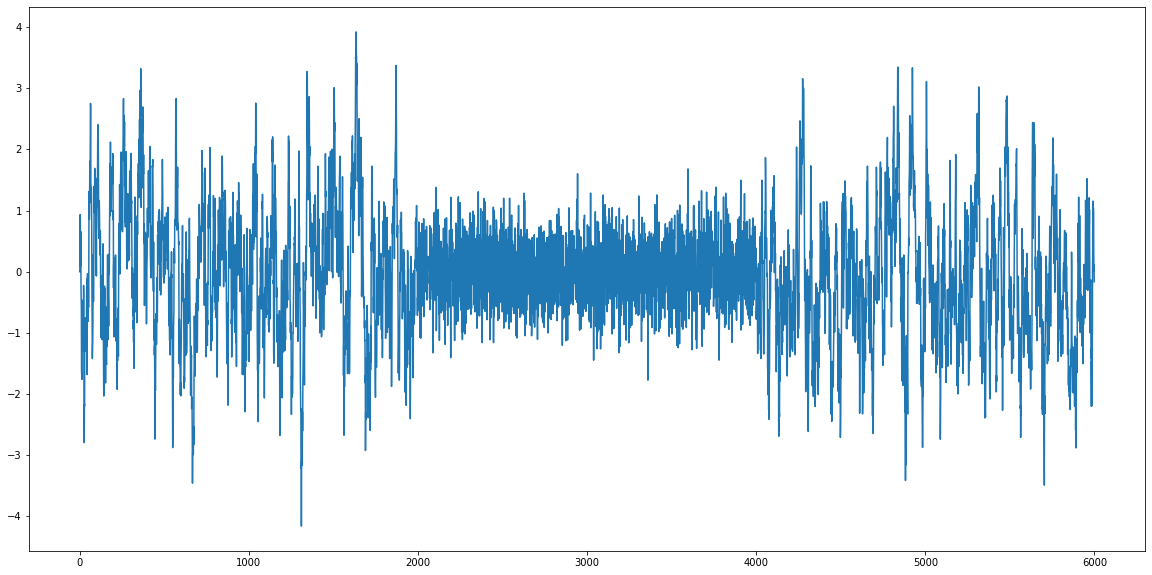

In [ ]:
# synthetic dat
n = 6000
z = np.zeros(n)
const = 0
e = np.random.normal(size=n,loc = 0,scale= 0.5)
for i in range(2,n):

    if n/3 <= i & i <= n*2/3:
        alpha = 0
        z[i] = const + alpha*z[i-1] + e[i]

    else:
        alpha = 0.9
        z[i] = const + alpha*z[i-1] + e[i]
    
ads1 = z 
plt.figure(figsize=(20,10))
plt.plot(ads1)

#### Example 2

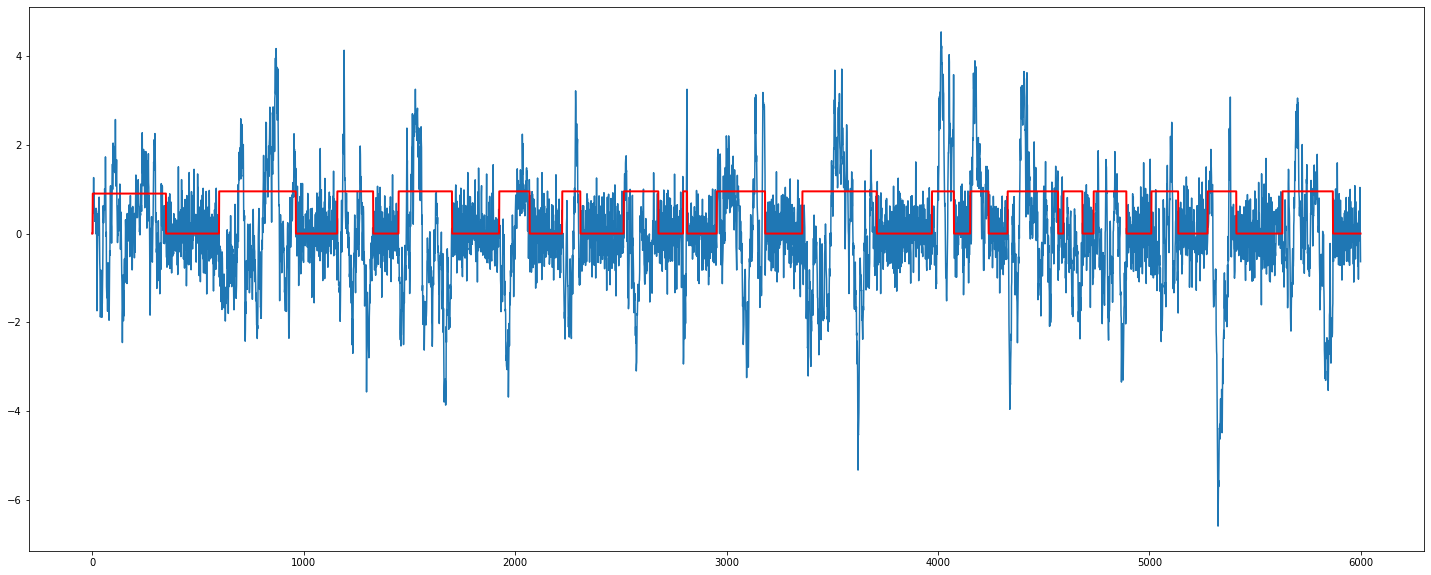

In [ ]:
z = np.zeros(n)
const = 0
e = np.random.normal(size=n,loc = 0,scale= 0.5)
prob = 0.99995
state = np.array([0, 0.95])
init = 2
tf = np.array([False, True])

count = 1
alpha = 0.9
hist = np.zeros(n)
hist_p = np.zeros(n)
hist_c = np.zeros(n)
temp = np.random.uniform(low=0, high=1, size=n)

for i in range(2,n):
    
    if temp[i] > prob**count:
        tf = np.logical_not(tf)
        alpha = state[tf]
        prob = 0.99995
        count = 1
    
    else:
        count = count + 1
    
    hist[i] = alpha
    hist_p[i] = prob**count
    hist_c[i] = count
    z[i] = const + alpha*z[i-1] + e[i]

ads2=z
plt.figure(figsize=(25,10))
plt.plot(ads2)
plt.plot(hist, color='red', linewidth= 2)

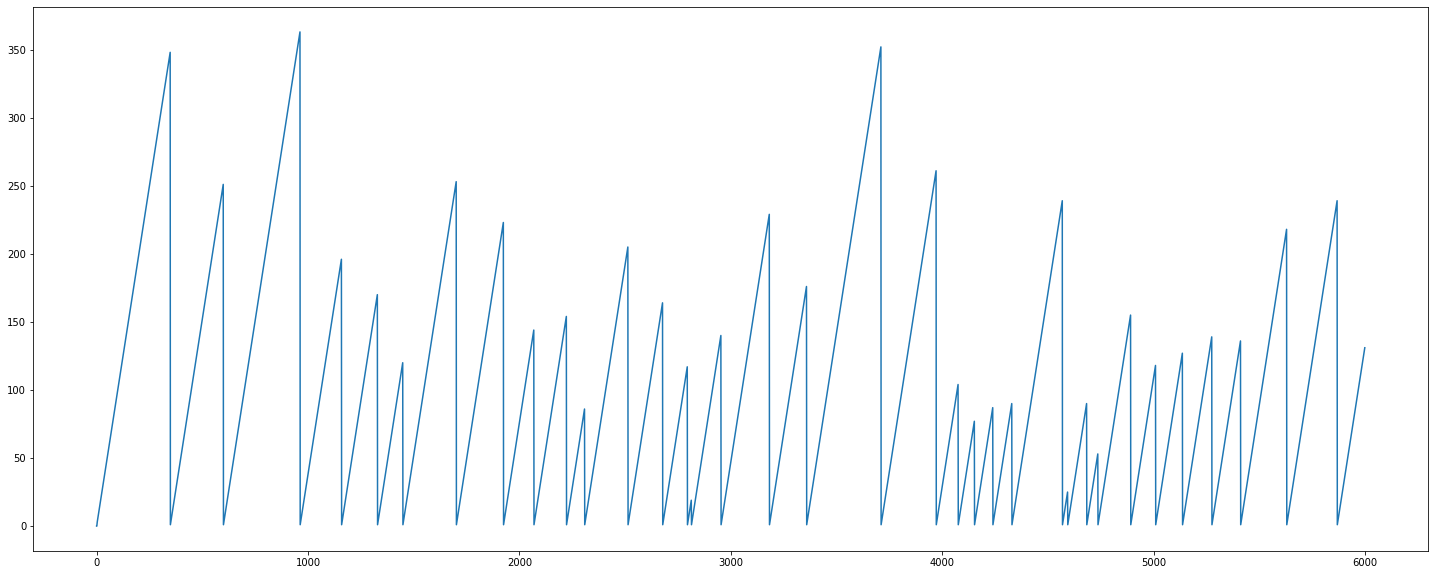

In [ ]:
plt.figure(figsize=(25,10))
plt.plot(hist_c)

# Main Functions

In [ ]:
def get_data_split(data_ready, lookback, test_length):
    
    data = data_ready.iloc[-test_length-lookback:,:]
    length = data.shape[0]
    train_starts = np.arange(0, length - lookback,1)
    # to make the train_starts and test_starts have the same number of elements
    test_starts = np.arange(lookback, length + 1, 1)[:len(train_starts)] 
    trains = [data.iloc[s:s+lookback] for s in train_starts]
    tests = [data.iloc[s:s+1] for s in test_starts]
    print('Split Done. Train Start')
    #print('training set len:', len(trains))
    #print('test set len:', len(tests))
    return trains, tests

def get_lag_diff(raw_data, order, target, exo=True):
    p = order - 1 
    X = raw_data.copy()
    # Generate lag variables 
    composite_col = X.columns[X.columns != target]
    X['y_pch'] = X[target].diff()
    X['y_pch_true'] = X['y_pch'].shift(-1)

    if exo:
        X[composite_col + '_pch'] = X[composite_col].diff()
        # make lag p variables and drop
        for i in range(0, p):
            X['y_pch_' + str(i+1)] = X['y_pch'].shift(i+1)
            X[composite_col + ('_' + str(i+1))] = X[composite_col + '_pch'].shift(i+1)      
    else:
        for i in range(0, p):
            X['y_pch_' + str(i+1)] = X['y_pch'].shift(i+1)

    # drop price series
    # don't drop target because we need to compare later
    X.drop(columns=composite_col, inplace=True) 
    X.dropna(inplace=True)
    print('Lag %d Diff Generated' %order)
    return X
  
from sklearn.linear_model import LinearRegression

def get_moving_pred(raw_data, order, test_length, target, exo=True):
    X = raw_data.copy()
    # generate diff and its lag variables
    data = get_lag_diff(X, order, target)
    print(target)
    

    lookback = [25, 50, 100, 250, 500, 1000]
    result = pd.DataFrame(data= np.zeros(shape=(len(lookback), test_length)),index=lookback)
     
    df_err_model = pd.DataFrame([])

    for num, n in enumerate(lookback):

        # split the data with different lookback n
        trains, tests = get_data_split(data_ready = data, lookback = n, test_length = test_length)
        print('Lookback : %d' %n)

        pred_price = np.array([])
        true_price = np.array([])

        for i in range(len(trains)):
            
            iteration_start = time.monotonic()
            X_train = trains[i].drop(columns=['y_pch_true', target])
            X_test = tests[i].drop(columns=['y_pch_true', target])
            Y_train = trains[i]['y_pch_true']
                
            model_fit = LinearRegression().fit(X_train, Y_train)
 
            pred_diff = model_fit.predict(X_test.values)
            
            # recover price using predicted difference after feature selection
            true_price = np.append(true_price, trains[i][target].iloc[-1:].values+ trains[i]['y_pch_true'].iloc[-1:].values)
            pred_price = np.append(pred_price, trains[i][target].iloc[-1:].values + pred_diff)
            
            #print(selected_params)
            iteration_end = time.monotonic()
            if(i % 499 == 1):
                print('{:.2f}%'.format(i/(len(trains)+1)*100))
                print("Iter time of : " , iteration_end - iteration_start)

        err_metric = evaluate(true_price, pred_price)
        df = pd.DataFrame(err_metric.items())
        df = df.transpose()
        df.columns = df.iloc[0]
        df = df.drop(df.index[[0]]).astype(float) # change to float to use round(3)
        df['lookback']=str(n)
        df_err_model = df_err_model.append(df, ignore_index = True)
        

        result.iloc[num,] = pred_price
  
  
    return  true_price, result, df_err_model

# Main Data

In [ ]:
df = pd.DataFrame({'y':ads2})

# Test

In [ ]:
n_test = 3000
true_price, result, df_err_model = get_moving_pred(df,3,n_test,'y')

Lag 3 Diff Generated
y
Split Done. Train Start
Lookback : 25
0.03%
Iter time of :  0.003562138999996023
16.66%
Iter time of :  0.0032072639999967123
33.29%
Iter time of :  0.003164538999982369
49.92%
Iter time of :  0.0031986079999910544
66.54%
Iter time of :  0.0029441559999838773
83.17%
Iter time of :  0.0028961229999993066
99.80%
Iter time of :  0.00280693099998075
Split Done. Train Start
Lookback : 50
0.03%
Iter time of :  0.003320989000002328
16.66%
Iter time of :  0.0029553960000043844
33.29%
Iter time of :  0.0030974839999942105
49.92%
Iter time of :  0.0032701769999903263
66.54%
Iter time of :  0.002992355999992924
83.17%
Iter time of :  0.002751243000005843
99.80%
Iter time of :  0.0031145089999995434
Split Done. Train Start
Lookback : 100
0.03%
Iter time of :  0.004068828000015401
16.66%
Iter time of :  0.0035041190000129063
33.29%
Iter time of :  0.0032609209999918676
49.92%
Iter time of :  0.0030051389999812272
66.54%
Iter time of :  0.003017282000001842
83.17%
Iter time of

# Test Set

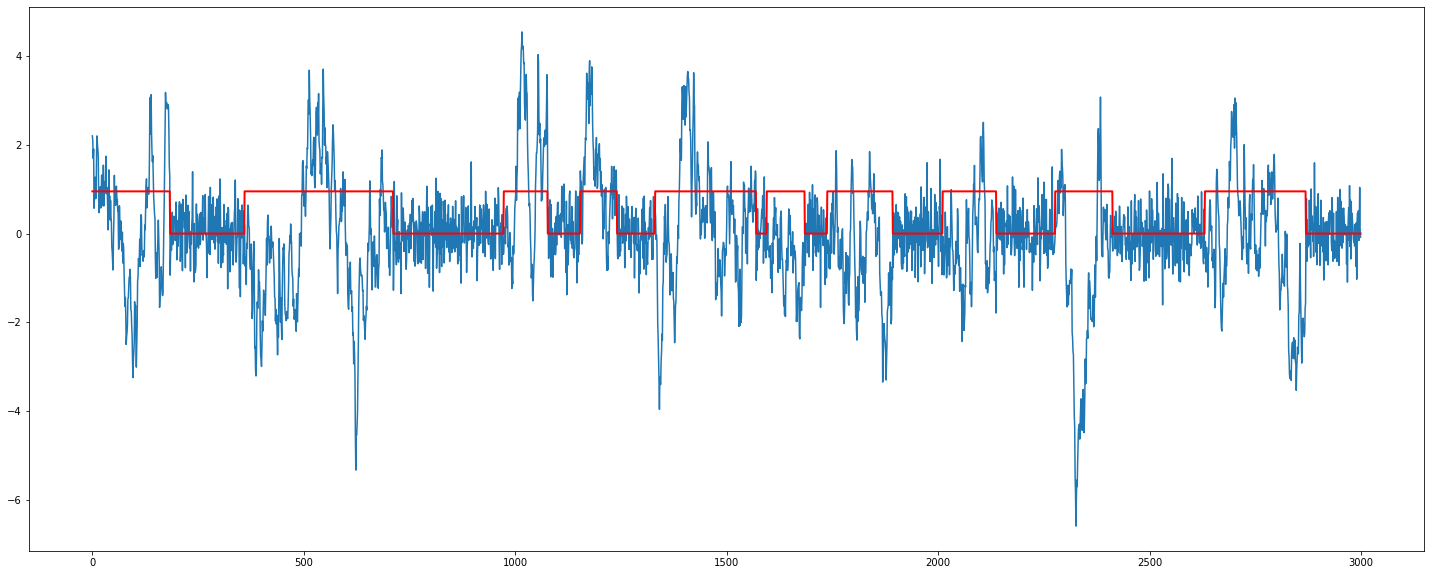

In [ ]:
true_price == ads2[2999:-1]
plt.figure(figsize=(25,10))
plt.plot(ads2[2999:-1])
plt.plot(hist[2999:-1], color='red', linewidth= 2)

In [ ]:
result

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2960,2961,2962,2963,2964,2965,2966,2967,2968,2969,2970,2971,2972,2973,2974,2975,2976,2977,2978,2979,2980,2981,2982,2983,2984,2985,2986,2987,2988,2989,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
25,1.597790,2.186803,2.116832,1.842720,2.072746,0.700138,1.106109,1.010363,1.362743,0.820767,1.039144,1.752003,2.081169,2.036303,2.000898,1.796554,1.006531,0.622079,0.654813,0.732472,0.943858,0.616319,0.957475,1.223755,0.573460,0.955520,0.427439,1.794685,0.382997,0.732123,1.153251,0.840745,1.032970,1.934146,1.005064,1.010369,1.127324,0.840542,-0.090312,-0.149524,...,0.631225,0.724097,0.497999,-0.022368,0.300240,-0.015533,0.751422,-0.950873,0.836515,-1.503676,-0.611110,-0.177116,0.905533,-0.804607,1.962956,-0.920920,1.815412,-1.557238,1.106253,-0.260405,0.621242,0.380834,0.411464,-0.019736,-0.247360,-0.055906,-0.710759,0.374239,0.510748,-1.482724,1.279967,-2.150241,-0.091965,0.574082,0.091405,1.107226,-0.379643,-0.787711,1.773946,0.538569
50,1.493444,2.171779,2.082788,1.753755,2.216839,0.470533,1.150849,0.911570,1.311686,0.684821,0.923952,1.721319,2.020436,1.971961,1.998691,1.889495,0.864943,0.691430,0.668226,0.658232,1.053131,0.537974,0.925642,1.278599,0.618220,1.089846,0.573907,1.713860,0.526207,0.793928,1.186773,0.904007,1.165902,1.871250,0.935947,1.154961,1.094218,0.779311,0.140678,0.245781,...,0.583333,0.722023,0.512383,-0.059087,0.276018,-0.044462,0.765761,-0.955871,0.874275,-1.454931,-0.841598,-0.175913,1.006644,-0.773149,1.771332,-0.726606,1.717151,-1.367095,1.023430,-0.361706,0.578395,0.395604,0.479485,0.084233,-0.174914,-0.019042,-0.646225,0.288891,0.548952,-1.252660,1.124388,-1.940156,-0.145320,0.376992,0.069571,1.027338,-0.315314,-0.500259,1.607576,0.512484
100,1.256662,2.118936,2.211478,1.708021,2.555841,0.566201,1.029926,0.840358,1.422166,0.710325,0.754368,1.633834,2.048098,2.022607,2.056051,2.137548,0.967405,0.683059,0.664943,0.609659,1.132050,0.486286,0.870659,1.402752,0.553944,1.173005,0.403405,1.792932,0.511274,0.770639,1.198570,0.811756,1.055038,1.918090,0.863690,1.181544,1.121323,0.857423,0.103692,0.183784,...,0.638750,0.691038,0.453670,-0.043660,0.312978,-0.012510,0.714916,-0.929302,0.826639,-1.401173,-0.661722,-0.251566,0.999849,-0.844867,1.766714,-0.735740,1.683720,-1.269535,1.009988,-0.335480,0.573181,0.376663,0.459949,0.086303,-0.166392,-0.027589,-0.637743,0.230039,0.539519,-1.185368,1.019206,-1.872359,-0.206377,0.366137,0.054482,1.023029,-0.212183,-0.547040,1.420366,0.544849
250,1.305439,2.096876,2.211656,1.710949,2.441560,0.683937,0.900639,0.843467,1.386461,0.759693,0.697708,1.592574,2.103418,2.040625,2.018590,2.119198,0.993457,0.585050,0.600022,0.595080,1.163491,0.495250,0.787220,1.456469,0.555233,1.122343,0.390546,1.791185,0.603498,0.667962,1.186076,0.821035,0.995606,1.936858,0.894508,1.136439,1.146657,0.906987,0.103267,0.082327,...,0.621049,0.517298,0.259925,-0.082368,0.224697,-0.028154,0.391973,-0.854585,0.462419,-1.280362,-0.384424,0.213989,0.809280,-0.486365,1.442583,-0.557960,1.186444,-0.990898,0.911166,-0.135104,0.516393,0.327420,0.278206,-0.050233,-0.197845,-0.070461,-0.474267,0.266329,0.251821,-1.095569,0.716533,-1.534404,0.114537,0.554780,0.112086,0.789703,-0.270780,-0.214175,1.403874,0.277590
500,1.314378,2.087362,2.223106,1.717234,2.410352,0.735883,0.866119,0.835752,1.380103,0.784393,0.664285,1.543044,2.101535,2.055333,2.018241,2.132946,1.065913,0.584693,0.581632,0.571346,1.149212,0.516327,0.741630,1.443311,0.590792,1.094411,0.379135,1.736919,0.664138,0.640543,1.155422,0.830682,0.956575,1.910535,0.956969,1.131451,1.161489,0.960004,0.138240,0.018926,...,0.588465,0.551606,0.313255,-0.079252,0.254382,-0.051475,0.501894,-0.917322,0.599583,-1.355838,-0.410775,0.110707,0.846282,-0.576931,1.509497,-0.584683,1.254358,-1.001658,0.911692,-0.149872,0.509671,0.328853,0.296696,-0.029768,-0.191200,-0.066612,-0.479870,0.258038,0.272010,-1.061930,0.710859,-1.510139,0.091577,0.469708,0.122121,0.7

In [ ]:
df_err_model

,rmse,mda,mpda,mnda,mpp,mnp,lookback
0,0.855396,0.369790,0.384412,0.354882,0.377922,0.361206,25
1,0.831565,0.345115,0.346103,0.344108,0.349800,0.340440,50
2,0.815154,0.278093,0.282034,0.274074,0.283721,0.272423,100
3,0.798825,0.147716,0.149273,0.146128,0.151272,0.144186,250
4,0.802980,0.098366,0.105020,0.091582,0.105438,0.091214,500
5,0.803698,0.092031,0.102378,0.081481,0.102041,0.081757,1000


# Running MSE

In [ ]:
np.transpose(true_price).reshape(-1,1)

array([[ 2.19808838],
       [ 2.09270375],
       [ 1.69245047],
       ...,
       [ 1.03810026],
       [ 0.0868775 ],
       [-0.08080863]])

In [ ]:
np.array(([1,2],[3,4])) **2

array([[ 1,  4],
       [ 9, 16]])

In [ ]:
err = np.transpose(result)- np.transpose(true_price).reshape(-1,1)
sq_err = err ** 2 ## Squared error 

In [ ]:
# for i in range(2,10):
#    df['MA{}'.format(i)] = df.rolling(window=i).mean()

err.rolling(window=30).mean()

,25,50,100,250,500,1000
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2995,0.010050,0.013803,0.010732,0.011667,0.012374,0.011699
2996,-0.057379,-0.051959,-0.049898,-0.040151,-0.042012,-0.039403
2997,-0.081243,-0.066075,-0.066459,-0.048107,-0.047310,-0.045280
2998,-0.089292,-0.080929,-0.085965,-0.056022,-0.062062,-0.058299


In [ ]:
err.columns
err[[25,1000]]

,25,1000
0,-0.600298,-0.924797
1,0.094099,-0.006946
2,0.424382,0.563897
3,-0.058520,-0.196351
4,1.502473,1.930961
...,...,...
2995,1.265007,0.892308
2996,-0.583955,-0.406783
2997,-1.825811,-1.201474
2998,1.687068,1.193721


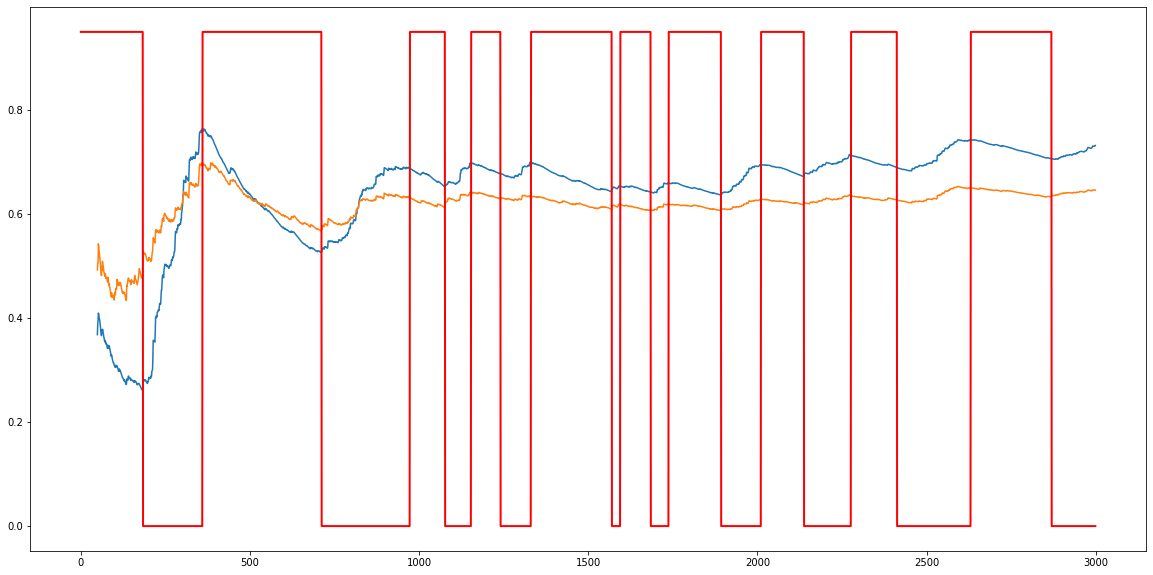

In [ ]:
plt.figure(figsize=(20,10))
#plt.plot(np.cumsum(err.iloc[:,-1]), color='black')
#plt.plot(np.cumsum(err.iloc[:,0]), color='blue')
plt.plot(sq_err[[25,1000]].expanding(50).mean())
#plt.plot((err[1000]-err[25]).rolling(window=30).mean())
plt.plot(hist[2999:-1], color='red', linewidth= 2)

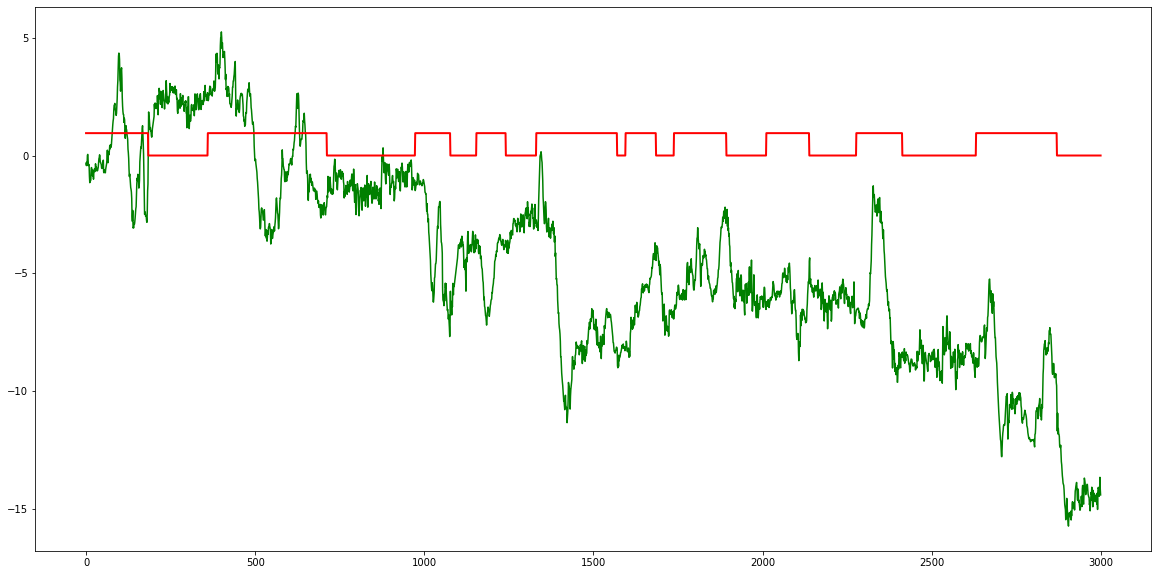

In [ ]:
plt.figure(figsize=(20,10))
#plt.plot(np.cumsum(err.iloc[:,-1]), color='black')
#plt.plot(np.cumsum(err.iloc[:,0]), color='blue')
plt.plot(np.cumsum(err.iloc[:,-1]) - np.cumsum(err.iloc[:,0]), color='green')
plt.plot(hist[2999:-1], color='red', linewidth= 2)

In [ ]:
target = 'y'
short_trains[0]
X_train = short_trains[0].drop(columns=['y_pch_true', target])
Y_train = short_trains[0]['y_pch_true']
model_fit = LinearRegression().fit(X_train, Y_train)
model_fit.coef_

array([-0.60244145, -0.38754646, -0.08409737])

In [ ]:
short_tests[0]

,y,y_pch,y_pch_true,y_pch_1,y_pch_2
2999,1.702626,0.495312,0.694841,-0.15053,-0.476093


In [ ]:
n_test = 3000
lookback = np.array([50, 100, 500, 1000, 3000, 6000, 10000, 12000, 15000])
result = pd.DataFrame(data= np.zeros(shape=(9, n_test)),index=lookback)
result, len(lookback)

(       0     1     2     3     4     5     ...  2994  2995  2996  2997  2998  2999
 50      0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0
 100     0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0
 500     0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0
 1000    0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0
 3000    0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0
 6000    0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0
 10000   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0
 12000   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0
 15000   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0
 
 [9 rows x 3000 columns], 9)

In [ ]:
n_test = 3000
true_price, df_err_model = get_moving_pred(df,3,3000,'y')

Lag 3 Diff Generated
y
Split Done. Train Start
Lookback : 50


NameError: ignored

In [ ]:
short_trains, short_tests = get_data_split(df, 100, 3000)
long_trains, long_tests = get_data_split(df, 3000, 3000)

Split Done. Train Start
Split Done. Train Start


In [ ]:
len(short_trains), short_tests[0], long_tests[0]

(3000,              0
 3000  0.454463,              0
 3000  0.454463)

In [ ]:
short_tests[0]

,0
3000,0.454463


In [ ]:
short_trains[0].tail

<bound method NDFrame.tail of              0
2900  0.385924
2901  0.330956
2902  0.181544
2903 -0.122010
2904  0.690534
...        ...
2995  2.435954
2996  1.832616
2997  1.829558
2998  1.111238
2999  0.642899

[100 rows x 1 columns]>